# NSC 325 Sweet Spot Identification
Elijah Flores, Aditya Holla, Jayant Bhaskaruni, Beshoy Shaker, and Ameera Aslam

The University of Texas at Austin

In [348]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

In [349]:
# Read in file
filename = 'sweetspot_UT_Austin.csv'
df = pd.read_csv(filename)

### Data Exploration and Cleaning

In [350]:
# Size and top 8 rows in dataset
print('Data size:', df.shape)
df.head(n=8)

Data size: (55, 14)


,Well Number,Well Name,Bottomhole X,Bottomhole Y,Co [MSTB],Cw (bbl),POROS,KX,KY,TD(MD),Cg (mmcf),FACIES,P_2020-1-6,P_2029-1-1
0,1,PO1_1,5064.04,13746.23,55.191600,1.617450e-04,0.128029,0.020377,0.020377,8551.7,157.119447,3,3491.971374,2992.403113
1,2,PO1_2,7668.40,13746.23,27.529400,1.394790e-04,0.101876,0.015088,0.015088,8579.9,69.831076,4,3501.327981,2947.374808
2,3,PO1_3,2459.67,13746.23,48.354000,1.973990e-04,0.119220,0.022396,0.022396,8557.1,134.781940,4,3493.763065,2904.053641
3,4,PO1_4,10272.76,13746.23,0.572057,1.440000e-07,0.064132,0.000091,0.000091,8635.5,1.101210,5,3519.775759,3301.826052
4,5,PO1_5,12877.11,13746.23,0.430394,8.560000e-08,0.063078,0.000067,0.000067,8718.6,0.435085,5,3547.347889,3365.597401
5,6,PO1_6,10272.76,11141.88,0.995444,3.840000e-07,0.071007,0.000168,0.000168,8555.5,2.792220,5,3493.232193,3196.746890
6,7,PO1_7,11430.25,11141.88,0.215019,6.030030e-01,0.069382,0.000162,0.000162,8589.1,0.523657,5,3504.380491,3126.405930
7,8,PO1_8,12877.11,11141.88,0.000000,1.244600e+00,0.074247,0.000270,0.000270,8638.6,0.000000,5,3520.804323,2949.434450


In [351]:
# Print out the amount of missing values
print((df == 0).sum())
df[(df == 0).any(axis=1)]

Well Number     0
Well Name       0
Bottomhole X    0
Bottomhole Y    0
Co [MSTB]       5
Cw (bbl)        0
POROS           0
KX              0
KY              0
TD(MD)          0
Cg (mmcf)       5
FACIES          0
P_2020-1-6      0
P_2029-1-1      0
dtype: int64


,Well Number,Well Name,Bottomhole X,Bottomhole Y,Co [MSTB],Cw (bbl),POROS,KX,KY,TD(MD),Cg (mmcf),FACIES,P_2020-1-6,P_2029-1-1
7,8,PO1_8,12877.11,11141.88,0.0,1.24460,0.074247,0.000270,0.000270,8638.6,0.0,5,3520.804323,2949.434450
8,9,PO1_9,14034.61,11141.88,0.0,1.30679,0.073380,0.000284,0.000284,8684.3,0.0,5,3535.967335,2954.485548
26,27,PO1_27,14034.61,8537.52,0.0,30.15660,0.116111,0.033130,0.010039,8645.4,0.0,4,3523.060526,2676.168143
27,28,PO1_28,14034.61,5933.16,0.0,37.77570,0.112872,0.012573,0.012573,8647.7,0.0,4,3523.823653,2694.598799
46,47,PO1_47,14034.61,3328.80,0.0,87.57740,0.143755,0.038000,0.038000,8691.2,0.0,3,3538.256717,2515.127738


In [352]:
# Well number and name are redundant (can use row index) and can be removed.
df.drop(columns=['Well Number', 'Well Name'], inplace=True)
df.head()

,Bottomhole X,Bottomhole Y,Co [MSTB],Cw (bbl),POROS,KX,KY,TD(MD),Cg (mmcf),FACIES,P_2020-1-6,P_2029-1-1
0,5064.04,13746.23,55.191600,1.617450e-04,0.128029,0.020377,0.020377,8551.7,157.119447,3,3491.971374,2992.403113
1,7668.40,13746.23,27.529400,1.394790e-04,0.101876,0.015088,0.015088,8579.9,69.831076,4,3501.327981,2947.374808
2,2459.67,13746.23,48.354000,1.973990e-04,0.119220,0.022396,0.022396,8557.1,134.781940,4,3493.763065,2904.053641
3,10272.76,13746.23,0.572057,1.440000e-07,0.064132,0.000091,0.000091,8635.5,1.101210,5,3519.775759,3301.826052
4,12877.11,13746.23,0.430394,8.560000e-08,0.063078,0.000067,0.000067,8718.6,0.435085,5,3547.347889,3365.597401


In [353]:
# Rename column headers to be more human-readable
mappings = {
    'Bottomhole X': 'bh_x',         # Bottomhole X-coordinate
    'Bottomhole Y': 'bh_y',         # Bottomhole Y-coordinate
    'Co [MSTB]':'oil_prod_mstb',    # Cumulative oil production, thousand stock tank barrels
    'Cw (bbl)':'water_prod_bbl',    # Cumulative water production, barrels
    'POROS':'porosity',             # Porosity
    'KX':'perm_x',                  # X permeability
    'KY':'perm_y',                  # Y permeability
    'TD(MD)':'total_depth_md',      # Total depth (measured depth)
    'Cg (mmcf)':'gas_prod_mmcf',    # Gas production, million cubic feet
    'FACIES':'facies',              # Facies
    'P_2020-1-6':'past_pressure',   # Pressure on January 6, 2020
    'P_2029-1-1':'future_pressure'  # Predicted pressure on January 1, 2029
}

df.rename(columns=mappings, inplace=True)
df.head()

,bh_x,bh_y,oil_prod_mstb,water_prod_bbl,porosity,perm_x,perm_y,total_depth_md,gas_prod_mmcf,facies,past_pressure,future_pressure
0,5064.04,13746.23,55.191600,1.617450e-04,0.128029,0.020377,0.020377,8551.7,157.119447,3,3491.971374,2992.403113
1,7668.40,13746.23,27.529400,1.394790e-04,0.101876,0.015088,0.015088,8579.9,69.831076,4,3501.327981,2947.374808
2,2459.67,13746.23,48.354000,1.973990e-04,0.119220,0.022396,0.022396,8557.1,134.781940,4,3493.763065,2904.053641
3,10272.76,13746.23,0.572057,1.440000e-07,0.064132,0.000091,0.000091,8635.5,1.101210,5,3519.775759,3301.826052
4,12877.11,13746.23,0.430394,8.560000e-08,0.063078,0.000067,0.000067,8718.6,0.435085,5,3547.347889,3365.597401


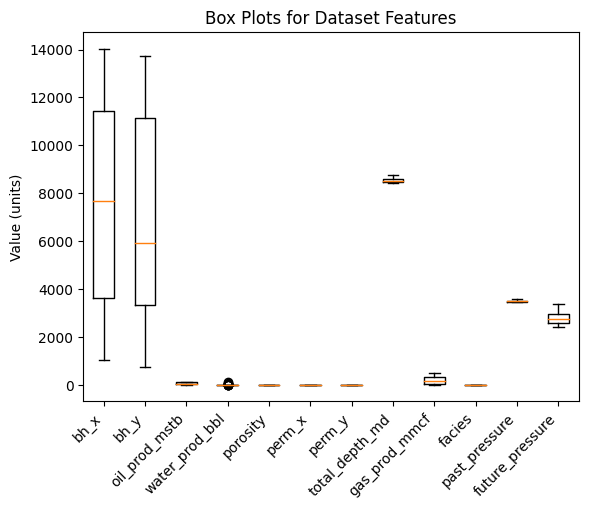

In [354]:
# Boxplots to check for outliers
plt.boxplot(df, labels=df.columns)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Value (units)')
plt.title('Box Plots for Dataset Features')
plt.show()

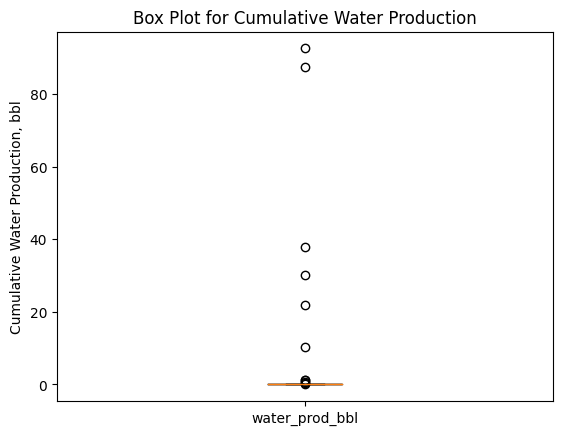

In [355]:
# Water production box plot
plt.boxplot(df['water_prod_bbl'], labels=['water_prod_bbl'])
plt.title('Box Plot for Cumulative Water Production')
plt.ylabel('Cumulative Water Production, bbl')
plt.show()

In [356]:
# One-hot encode facies since it is categorical
df = pd.get_dummies(df, columns=['facies'], drop_first=True)
df.head()

,bh_x,bh_y,oil_prod_mstb,water_prod_bbl,porosity,perm_x,perm_y,total_depth_md,gas_prod_mmcf,past_pressure,future_pressure,facies_2,facies_3,facies_4,facies_5
0,5064.04,13746.23,55.191600,1.617450e-04,0.128029,0.020377,0.020377,8551.7,157.119447,3491.971374,2992.403113,False,True,False,False
1,7668.40,13746.23,27.529400,1.394790e-04,0.101876,0.015088,0.015088,8579.9,69.831076,3501.327981,2947.374808,False,False,True,False
2,2459.67,13746.23,48.354000,1.973990e-04,0.119220,0.022396,0.022396,8557.1,134.781940,3493.763065,2904.053641,False,False,True,False
3,10272.76,13746.23,0.572057,1.440000e-07,0.064132,0.000091,0.000091,8635.5,1.101210,3519.775759,3301.826052,False,False,False,True
4,12877.11,13746.23,0.430394,8.560000e-08,0.063078,0.000067,0.000067,8718.6,0.435085,3547.347889,3365.597401,False,False,False,True


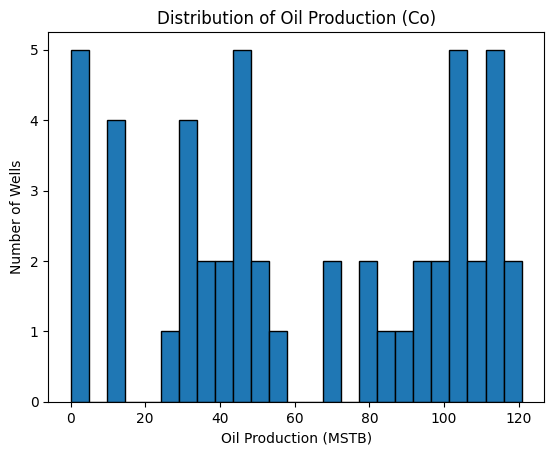

In [357]:
# Treat the 0s as NaN - missing values
temp_df = df['oil_prod_mstb'].replace(0, np.nan).dropna()

# Histogram for oil production
plt.hist(temp_df, bins=25, edgecolor='black')
plt.title('Distribution of Oil Production (Co)')
plt.xlabel('Oil Production (MSTB)')
plt.ylabel('Number of Wells')
plt.show()

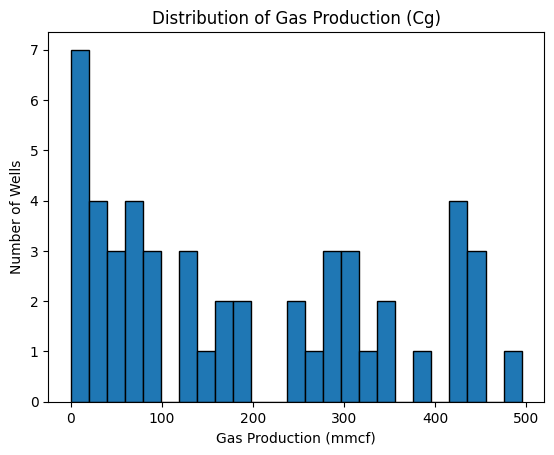

In [358]:
# Treat the 0s as NaN - missing values
temp_df = df['gas_prod_mmcf'].replace(0, np.nan).dropna()

# Histogram for gas production
plt.hist(temp_df, bins=25, edgecolor='black')
plt.title('Distribution of Gas Production (Cg)')
plt.xlabel('Gas Production (mmcf)') 
plt.ylabel('Number of Wells')    
plt.show()

In [359]:
# Missing value imputation

# Replace 0s with NaN 
df['oil_prod_mstb'].replace(0, np.nan, inplace=True)
df['gas_prod_mmcf'].replace(0, np.nan, inplace=True)

# Median imputation (safer than mean due to outliers)
df['oil_prod_mstb'].fillna(df['oil_prod_mstb'].median(), inplace=True)
df['gas_prod_mmcf'].fillna(df['gas_prod_mmcf'].median(), inplace=True)

# Check that there are no more missing values
print(df[['oil_prod_mstb', 'gas_prod_mmcf']].isna().sum())

oil_prod_mstb    0
gas_prod_mmcf    0
dtype: int64


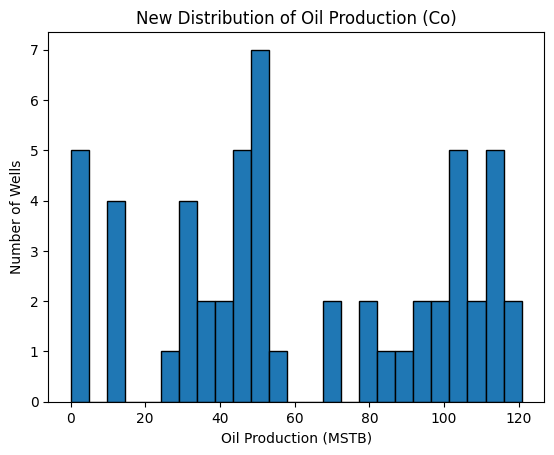

In [360]:
# Histogram for oil production after imputation
plt.hist(df['oil_prod_mstb'], bins=25, edgecolor='black')
plt.title('New Distribution of Oil Production (Co)')
plt.xlabel('Oil Production (MSTB)')
plt.ylabel('Number of Wells')
plt.show()

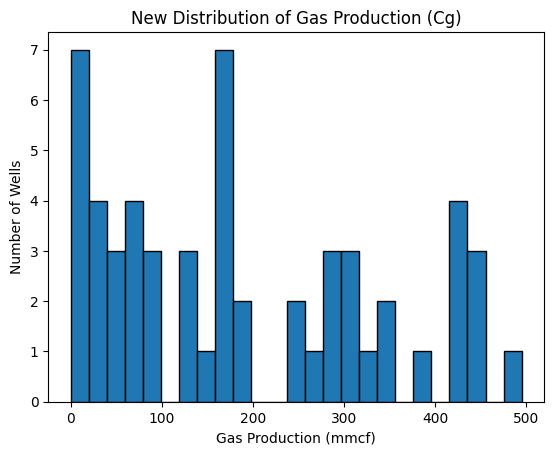

In [361]:
# Histogram for gas production after imputation
plt.hist(df['gas_prod_mmcf'], bins=25, edgecolor='black')
plt.title('New Distribution of Gas Production (Cg)')
plt.xlabel('Gas Production (mmcf)')
plt.ylabel('Number of Wells')
plt.show()

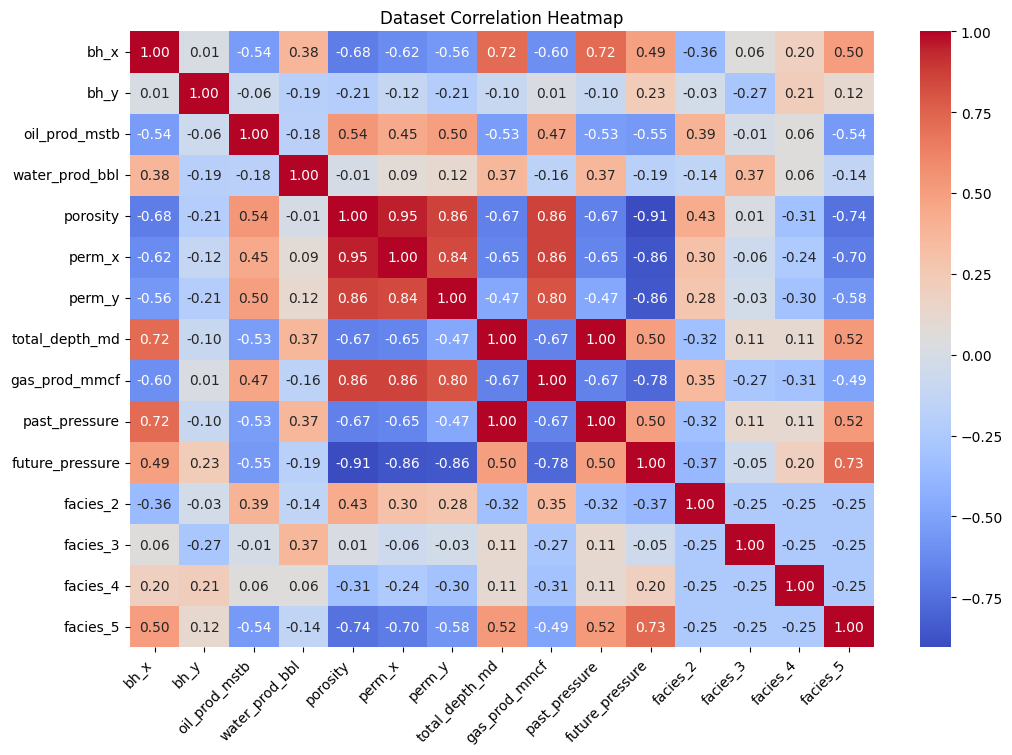

In [362]:
# Heatmap to display correlations
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Dataset Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

### Model Creation

In [363]:
# Define target (Y) and features (X)
X = df.drop(columns=['oil_prod_mstb'])  
y = df['oil_prod_mstb']

# Train test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [364]:
# Linear regression
linear = LinearRegression()
linear.fit(X_train, y_train)

# Predictions
y_pred_ols = linear.predict(X_test)

# Evaluation
print("Linear Regression R²:", r2_score(y_test, y_pred_ols))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ols)))

# Coefficients ordinary least squares (OLS)
coeffs_ols = pd.Series(linear.coef_, index=X.columns).sort_values()
print("\nTop coefficients (OLS):\n", coeffs_ols.tail(10))

Linear Regression R²: 0.3127424030650573
Linear Regression RMSE: 32.109357258109064

Top coefficients (OLS):
 future_pressure   -1.010413e-01
bh_x              -1.677472e-03
bh_y              -1.882120e-04
gas_prod_mmcf      1.984988e-03
facies_2           1.600848e+01
facies_3           1.661414e+01
facies_5           2.045593e+01
facies_4           2.731511e+01
perm_y             8.887311e+02
past_pressure      1.469837e+07
dtype: float64


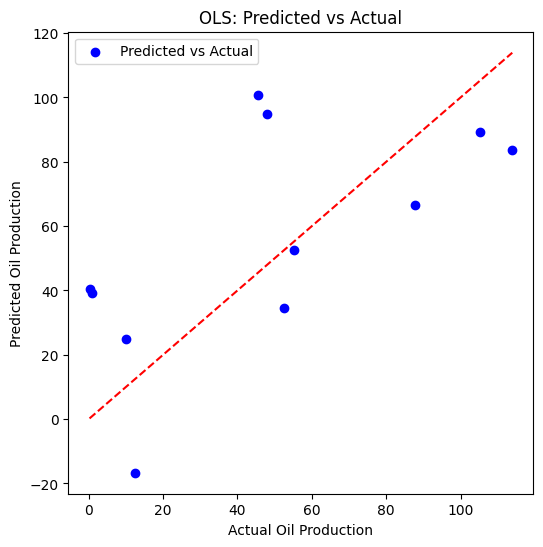

In [365]:
# Visualize predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ols, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  
plt.xlabel('Actual Oil Production')
plt.ylabel('Predicted Oil Production')
plt.title('OLS: Predicted vs Actual')
plt.legend()
plt.show()

# Linear model not capturing relationship well - dots far off


In [366]:
# # Ridge with cross-validation to pick best alpha
# alphas = np.logspace(-3, 3, 13)  # 0.001 to 1000

# ridge_cv = Pipeline([
#     ('scaler', StandardScaler()),  # scale features so Ridge is fair
#     ('ridge', RidgeCV(alphas=alphas))
# ])

# ridge_cv.fit(X_train, y_train)
# y_pred_ridge = ridge_cv.predict(X_test)

# print("Ridge Best alpha:", ridge_cv.named_steps['ridge'].alpha_)
# print("Ridge R²:", round(r2_score(y_test, y_pred_ridge), 4))
# print("Ridge RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_ridge)), 4))

# plt.figure(figsize=(6,6))
# plt.scatter(y_test, y_pred_ridge, color='green', label='Ridge Predicted vs Actual')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.xlabel('Actual Oil Production')
# plt.ylabel('Predicted Oil Production')
# plt.title('Ridge: Predicted vs Actual')
# plt.legend()
# plt.show()

# lasso_cv = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lasso', LassoCV(cv=5, max_iter=5000))
# ])

# lasso_cv.fit(X_train, y_train)
# y_pred_lasso = lasso_cv.predict(X_test)

# print("Lasso Best alpha:", lasso_cv.named_steps['lasso'].alpha_)
# print("Lasso R²:", round(r2_score(y_test, y_pred_lasso), 4))
# print("Lasso RMSE:", round(np.sqrt(mean_squared_error(y_test, y_pred_lasso)), 4))

# # Which features Lasso kept
# coeffs_lasso = pd.Series(lasso_cv.named_steps['lasso'].coef_, index=X.columns)
# print("\nLasso coefficients:\n", coeffs_lasso[coeffs_lasso != 0])




# coef_df = pd.DataFrame({
#     'OLS': ols.coef_,
#     'Ridge': ridge_cv.named_steps['ridge'].coef_,
#     'Lasso': lasso_cv.named_steps['lasso'].coef_
# }, index=X.columns).sort_values(by='OLS')

# coef_df.plot(kind='barh', figsize=(8,10))
# plt.title('Coefficients: OLS vs Ridge vs Lasso')
# plt.xlabel('Coefficient value')
# plt.tight_layout()
# plt.show()




In [367]:
# # porosity vs oil production (prediction feature vs target variable)
# x = df['porosity']
# y = df['oil_prod_mstb']

# slope, intercept, r_value, p_value, std_err = st.linregress(x, y)

# print("Slope:", slope)
# print("Intercept:", intercept)
# print("R²:", r_value**2)
# print("p-value:", p_value)
# print("Std Err:", std_err)

In [368]:
# plt.scatter(x, y)
# plt.plot(x, slope * x + intercept, color="red", label="Line of Best Fit")
# plt.xlabel("Porosity")
# plt.ylabel("Oil Production (MSTB)")
# plt.title("Linear Regression (porosity vs oil production)")
# plt.legend()
# plt.show()